# DNN: analysis with Keras of 2D data

- Marco Boscolo, 2157559
- Francesco La Rovere, 2164968
- Nicolò Montagner, 2165809
- Raffaele Sabatini 2165739

In [2]:
import numpy as np #Always usefull and to be used

import keras
import tensorflow.random as tf_r
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers
import keras_tuner

import matplotlib as mpl
import matplotlib.pyplot as plt

from useful import *


# default font
plt.rcParams['font.size'] = 13

%run useful.py

# training data
perc_train = 0.8

2025-02-27 18:25:16.111145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Useful Functions
def PlotPrediction(x, y, xM, xS, Model, whichData, whichModel):

    L = 8
    B = 10

    dX = .05
    X1 = np.arange(0, 10+dX, dX)
    LG = len(X1)
    X, Y = np.meshgrid(X1, X1)
    allXY = np.reshape((np.array((X,Y)).T), (LG**2,2))
    grid = np.random.rand(LG**2, L)*B
    grid[:,:2] = allXY
    grid_r = Standardize(grid, xM, xS)

    pred = Model.predict(grid_r)

    fig, AX = plt.subplots(1, 2, figsize = (16,8))

    ax = AX[0]
    ax.scatter(x[:,0], x[:,1], c=y, s=6)
    ax.set_title("Data", fontsize = 12)

    ax = AX[1]
    pred01=np.copy(pred)
    pred01[pred>0.5]=1
    pred01[pred<=0.5]=0


    ax.pcolormesh(X1, X1, pred01.reshape((LG, LG)))
    ax.set_title(f"Result of the fit with {whichData} data and {whichModel} model", fontsize = 13)

    plt.show()

## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


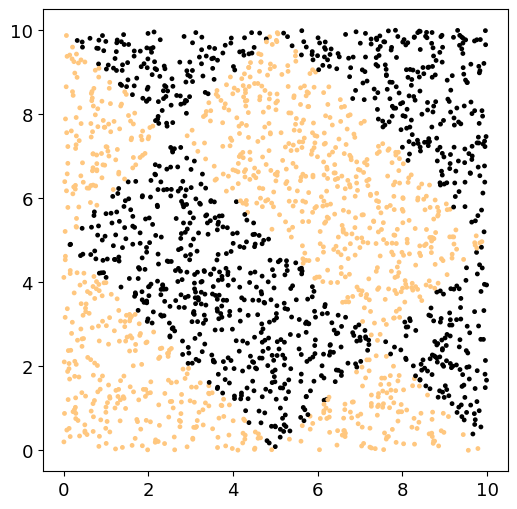

In [3]:
# Keras works with numpy arrays: just use them from the start
TYPE = 3

# data point size
L = 8
# span of each component
B = 10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x, axis=0)
x_std  = np.std(x, axis=0)


# dim. of a sample
L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [4]:
print("Before rescaling:\nMean value =", x_mean,"\nStd dev = ", x_std)

x = Standardize(x, x_mean,x_std)
print("After rescaling:\nMean value =", x.mean(axis=0), "\nStd dev =", x.std(axis=0))

Before rescaling:
Mean value = [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
Std dev =  [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]


NameError: name 'Standardize' is not defined

## Split training and test data

In [5]:
(x_train, y_train) = (x[0 : N_train], y[0 : N_train])
(x_valid, y_valid) = (x[N_train : ], y[N_train : ])
print("Train: ", len(x_train), "\t Validation: ", len(x_valid))

Train:  1600 	 Validation:  400


## Define the model with Keras / Tensorflow

In [6]:
# reproducibility (?)
np.random.seed(12345)
tf_r.set_seed(12345)

# We use case 1
CASE = 1

if CASE == 1:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(1,activation='sigmoid')) #sigmoid because we want a result between 0 and 1
    nepoch = 500
# as case 1 but one layer shorter
if CASE == 2:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(40,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(1,activation='sigmoid'))
    nepoch = 400
#deeper
if CASE == 3:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(1,activation='sigmoid'))
    nepoch = 400
    
print(OriginalModel.summary())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

None


## Optimization method and cost function

In [7]:
OriginalModel.compile(loss='binary_crossentropy', optimizer='RMSprop', #optimizer='adam',
              metrics=['accuracy'])

## Training

In [8]:
fit = OriginalModel.fit(x_train, y_train, epochs = nepoch, batch_size = 50, validation_data = (x_valid,y_valid), verbose=0)

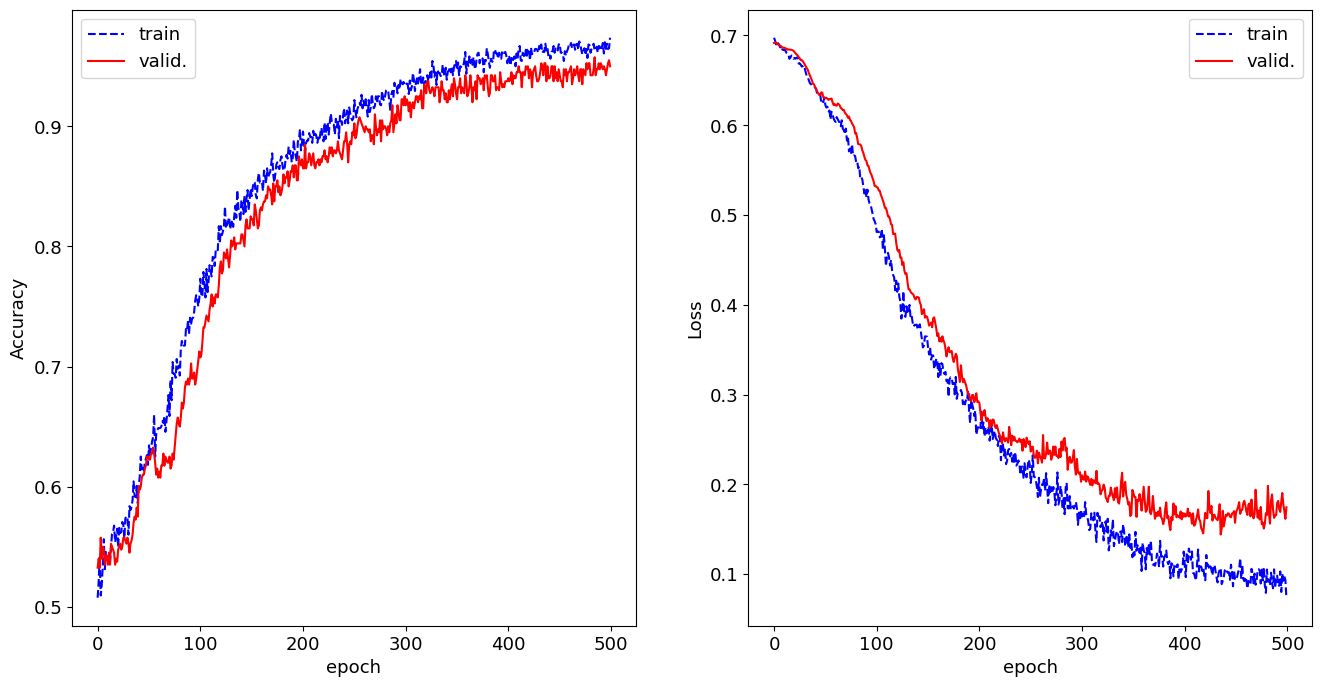

In [9]:
fig, AX = plt.subplots(1, 2, figsize = (16,8))

ax = AX[0]
ax.plot(fit.history['accuracy'], label="train", c="b", ls="--")
ax.plot(fit.history['val_accuracy'], label="valid.", c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax = AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


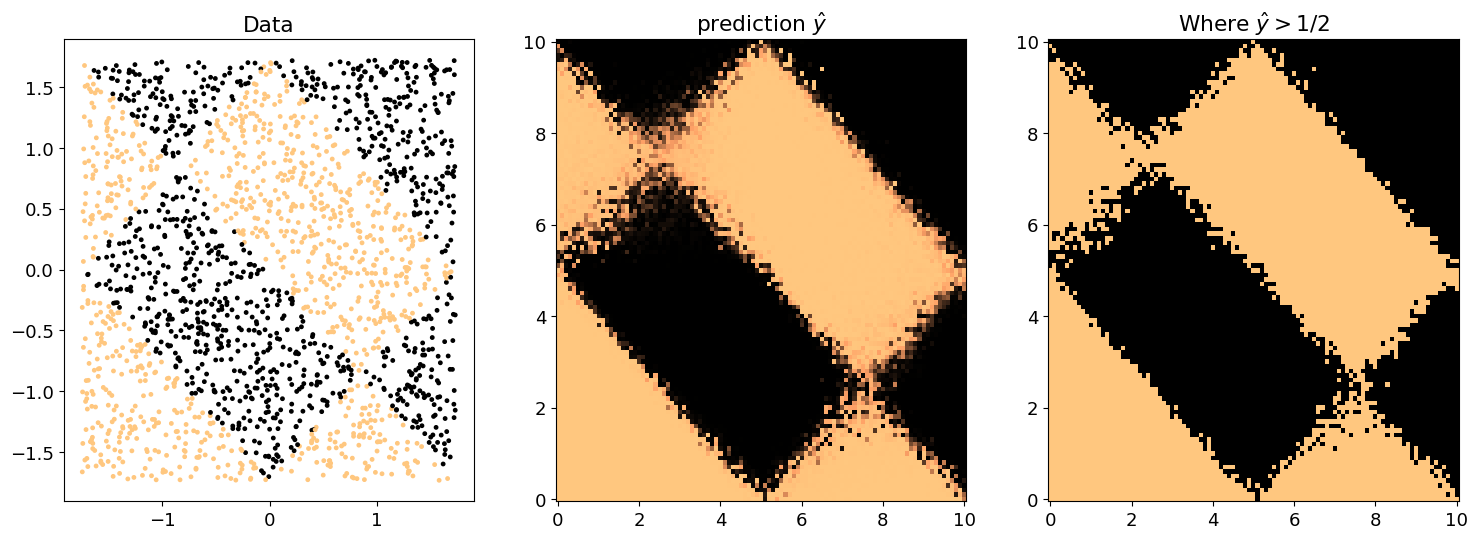

remember: these are 2 out of L=8 dimensions, of which L-2 contain random noise


In [10]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r = Standardize(grid, x_mean, x_std)

pred = OriginalModel.predict(grid_r)

fig, AX = plt.subplots(1, 3, figsize = (18,6.))

ax = AX[0]
ax.scatter(x[:,0],x[:,1], c=y, s=6)
ax.set_title("Data")


ax = AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")


ax = AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0

ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("Where $\\hat y > 1/2$")

plt.show()

print(f"remember: these are 2 out of L={L} dimensions, of which L-2 contain random noise")

# Implementing Random Search

We implement a random search using **keras_tuner** in order to find the best hyperparameters of the model into an hyperparameters space composed by the following:
- Layers of the model: from 1 to 6
- Neurons of the model: from 10 to 30 with steps of 5 
- Activation functions: ReLU, sigmoid, tanh, elu
- Optimizers: ADAM, RMSprop, SGD
- Dropout values: 0, 0.1, 0.2
- Learning rates: from 10e-6 to 10e-1

In [11]:
#We start by building the model with the list of hyperparameters listed above
def build_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers of the model
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(layers.Dense(
                #Define the units and the activation functions
                units=hp.Int(f"units_{i}", min_value=10, max_value=30, step=5),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "elu"]),
            )
        )
        #Define the dropout values of the model 
        model.add(layers.Dropout(rate=hp.Float("dropout", min_value = 0, max_value = 0.2, step = 0.05)))
        
    #Output layer is composed by 1 neuron since it's classification task
    model.add(layers.Dense(1, activation="sigmoid"))

    #Define the learning rate of the model 
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    model.compile(

        #Define the optimizers of the model
        optimizer=hp.Choice("optimizer", ["adam", "RMSprop", "SGD"]), loss="binary_crossentropy",
        metrics=["accuracy"])
    return model


build_model(keras_tuner.HyperParameters())

#After builiding the model we impose the tuning 
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 5,
    executions_per_trial = 1,
    overwrite = True,
)

tuner.search_space_summary()

#We search for "max_trials" iterations for the best hyperparameters
tuner.search(x_train, y_train, batch_size = 50, epochs = 340, validation_data=(x_valid,y_valid), verbose=1)

Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.9474999904632568

Best val_accuracy So Far: 0.9474999904632568
Total elapsed time: 00h 01m 00s


In [12]:
#It returns the model already trained
models = tuner.get_best_models(num_models=2)
models[0].summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (50, 8)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (50, 20)               │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (50, 20)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (50, 30)               │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (50, 30)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (50, 20)               │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (50, 20)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (50, 10)               │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (50, 10)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (50, 1)                │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651 (6.45 KB)

 Trainable params: 1,651 (6.45 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_layers: 4
units_0: 20
activation: tanh
dropout: 0.05
lr: 8.704670773745486e-05
optimizer: adam
units_1: 30
units_2: 20
units_3: 10
Score: 0.9075000286102295

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 30
activation: tanh
dropout: 0.2
lr: 0.008511079959131748
optimizer: RMSprop
Score: 0.8799999952316284

Trial 4 summary
Hyperparameters:
num_layers: 5
units_0: 25
activation: sigmoid
dropout: 0.15000000000000002
lr: 0.02342854362573016
optimizer: RMSprop
units_1: 25
units_2: 15
units_3: 10
units_4: 10
Score: 0.5874999761581421

Trial 2 summary
Hyperparameters:
num_layers: 1
units_0: 20
activation: sigmoid
dropout: 0.05
lr: 1.4130849490066179e-06
optimizer: RMSprop
units_1: 10
units_2: 30
Score: 0.5724999904632568

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 10
activation: sigmoid
dropout: 0.05
lr: 0.000667879255

# Augmentation --> Marco

In [14]:
max_array = [ max( x_train[:,i] ) for i in range(L) ]
min_array = [ min( x_train[:,i] ) for i in range(L) ]
center_point = []
N = 10000

for j in range(N):
    a = []
    a = [ np.random.uniform( min_array[i], max_array[i] ) for i in range(L)  ]
    center_point.append(a)
center_point = np.array(center_point)
epsilon = 2
thresold = 0.6

x_augum = []
y_augum = []

for i in range(N):
    mask =  np.sqrt( np.sum ( ( x_train - center_point[i,:] ) ** 2, axis = 1)    ) < epsilon
    inside_sphere = y_train[mask]
    if np.mean(inside_sphere) >= thresold or np.mean(inside_sphere) <= (1-thresold):
        
        x_augum.append( center_point[i,:] )
        y_augum.append( round(np.mean(inside_sphere) ) )

x_augum = np.array(x_augum)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# TODO
 Training and validation\


# Augmenting data

We used two approch:
* RAFFAELE SPIEGA MAGLIO IL TUO
* We add same little noise to the original data by the mean of small gaussain variables

The first approch here below:

1600
6653


Text(0.5, 1.0, 'Augmented data')

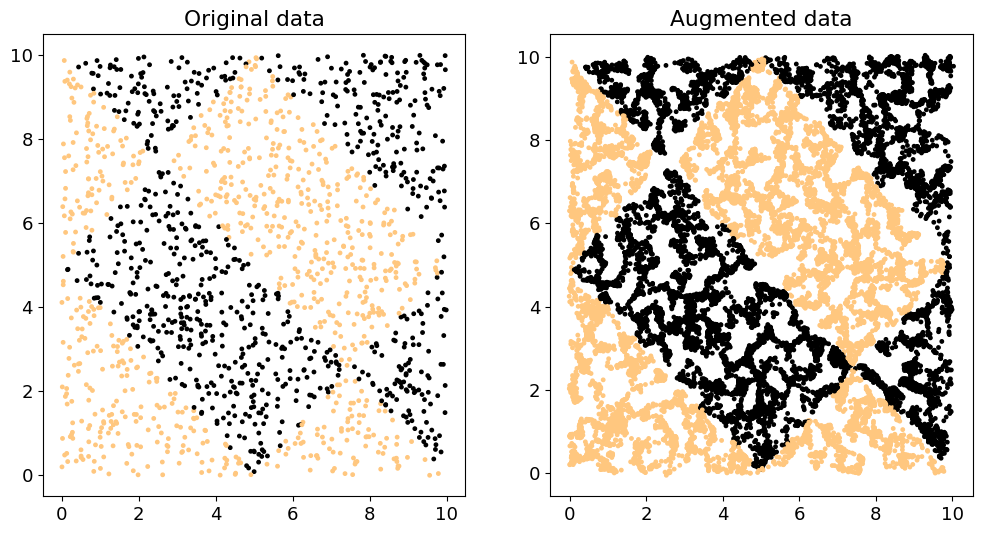

In [17]:
# For each point it finds the K closest points with same color and adds M points on the segment connecting them

def augment_data(x_train, y_train, K=2, M=3, keep_old=True, validation_size=10):
    augmented_x = np.array([])
    augmented_y = np.array([])
    
    if keep_old:
        augmented_x=x_train
        augmented_y=y_train
    
    for i in range( np.shape(y_train)[0] ):
        x, y = x_train[i], y_train[i]
        eq_colored_x = x_train[y_train == y]
        distances = [np.sqrt(np.sum( (x-z)**2) ) for z in eq_colored_x] 

        indices = np.argsort(distances)[1:K+1] # first index is the position of x (distance of x with itself is 0)
        closest_samples = [eq_colored_x[indx] for indx in indices]

        for close_x in closest_samples:
            for _ in range(M):
                new_x = close_x + (x-close_x)*np.random.uniform() + np.random.normal(0,0.025,8)

                #Validation of the new_x point
                dist = np.array([ np.sqrt(np.sum( (new_x-p)**2 )) for p in x_train ])
                validation_indices = np.argsort(dist)[:validation_size] 
                validation_labels = np.array([y_train[indx] for indx in validation_indices])
                
                mismatch = len(validation_labels[validation_labels != y])

                if mismatch/validation_size > 1/3:
                    continue
                else:
                    augmented_x = np.vstack([augmented_x, new_x])
                    augmented_y = np.append(augmented_y, y)

    return np.array(augmented_x), np.array(augmented_y)



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

size = 50
data = np.random.random((size, 8))
dummy_labels = np.random.choice((0, 1), size=size)
#print(np.shape(data))
print(len(y_train))
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=6)
axes[0].set_title("Original data") 

augm_data, augm_labels = augment_data(x_train, y_train, K=2, M=4, validation_size=15)
print(len(augm_labels))
#print("augmented data \n",np.shape(augm_data))
axes[1].scatter(augm_data[:, 0], augm_data[:, 1], c=augm_labels, s = 6)
axes[1].set_title("Augmented data") 

The second method with the gaussian noise. Note that we can iterate this process: we can build simulated data with noise starting from a simulated data itself, adding noise to noise, so trying to fill the empty gaps/spaces in the original dataset.

1600 8
4000 8


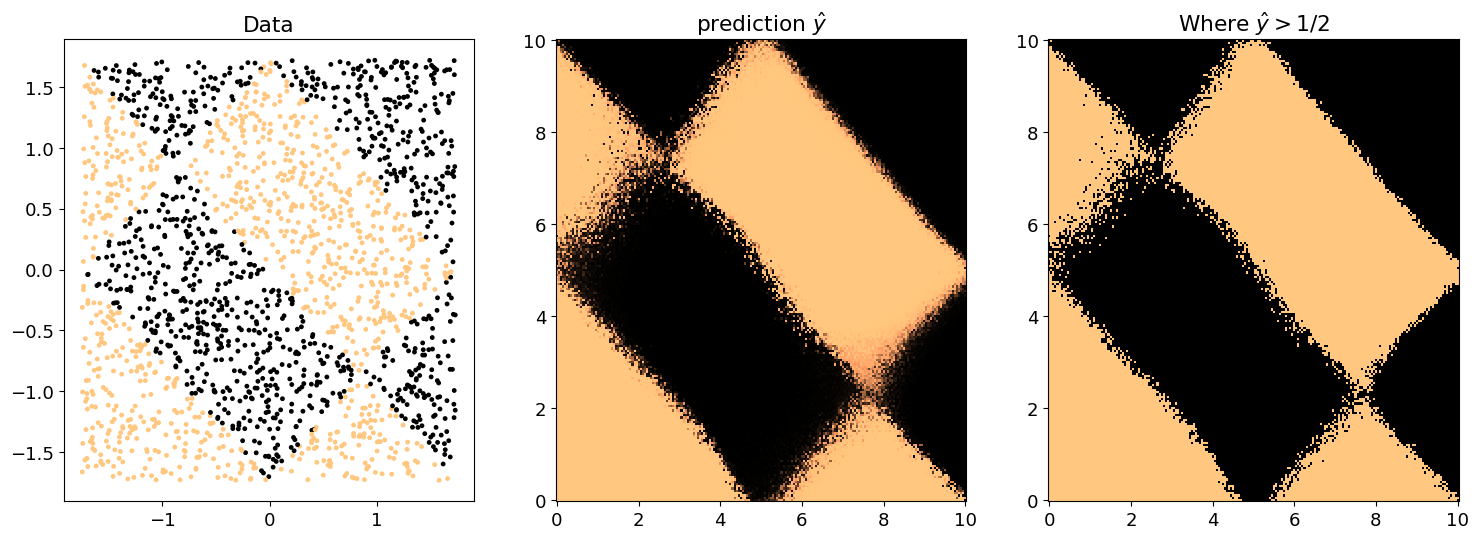

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


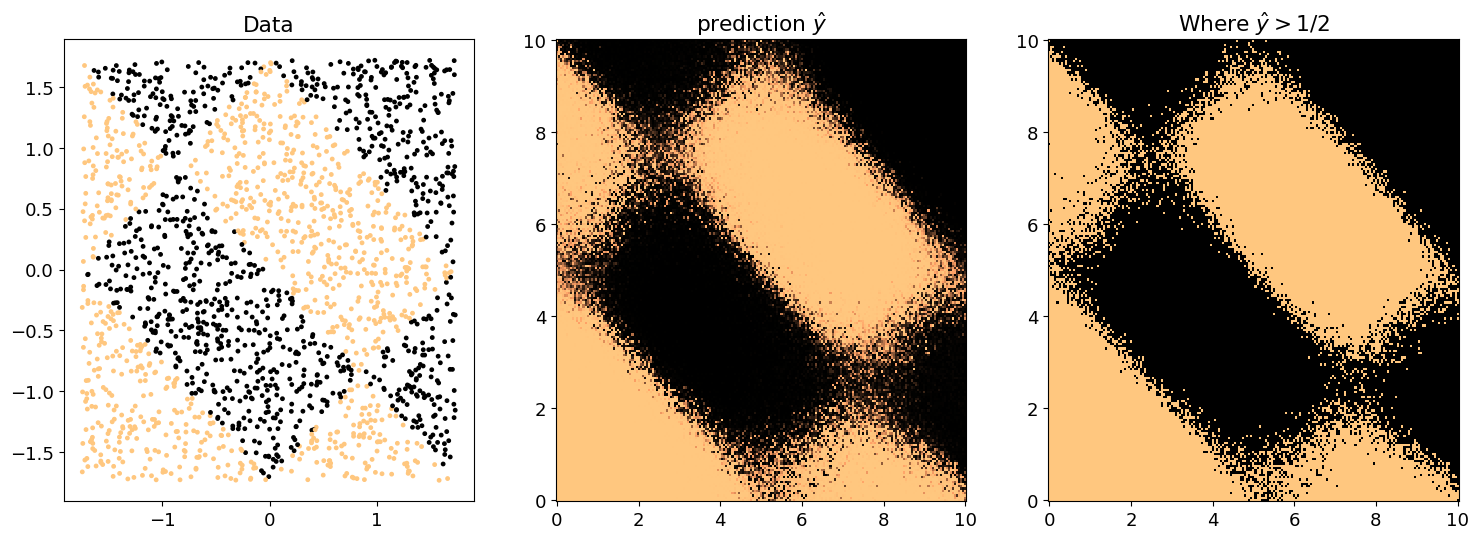

In [91]:
def augment_data_noise(x_train, y_train, N, mu=0, sigma=0.2): # mu and sigma parameters of the noise
    
    len_x = x_train.shape[0]
    L = x_train.shape[1]
    print(len_x,L)
    N = max(N, len_x) #we create at least a number of data equal to the starting ones

    quot      = N // len_x
    remainder = N % len_x
    
    index_all = []

    # duplicating the dataset "quot" times, so we'll cover the space equally as the starting data
    for i in range(0, quot):
        index = np.arange( x_train.shape[0] )
        np.random.shuffle(index)
        index_all = np.concatenate( (index_all,index) ).astype(int)

        
    # finally adding the remaing part of N modulo len_x
    index  = np.arange( x_train.shape[0] )
    chosen = np.random.choice(index, size=remainder, replace=False) #if we want we can also replicate the data
    index_all = np.concatenate( (index_all,chosen) ).astype(int)
    
    augmented_x = []
    augmented_y = []
    
    for j in index_all:
        noise = np.random.normal(mu, sigma, L)
        result = np.array(x_train[j,:]) + noise
        augmented_x.append( result )
        augmented_y.append( y_train[j] )

    return np.array(augmented_x), np.array(augmented_y)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=6)
axes[0].set_title("Original data") 


augm_data, augm_labels = augment_data_noise(x_train, y_train, N=4000, mu=0, sigma=0.1)
# we can iterate the process
augm_data, augm_labels = augment_data_noise(augm_data, augm_labels, N=8000, mu=0, sigma=0.1)

axes[1].scatter(augm_data[:, 0], augm_data[:, 1], c=augm_labels, s = 6)
axes[1].set_title("Augmented data") 

# Reduced sample

Generating half of the initial points, keeping the 80% of the dataset as training set

In [33]:
NRed = 1000

xRed, yRed = GenerateData(NRed, L = 8, B = 10, TYPE = 3)

xRed_mean = np.mean(xRed, axis=0)
xRed_std  = np.std(xRed, axis=0)

xRed = Standardize(xRed, xRed_mean, xRed_std)

NRed_train = int(perc_train*NRed)

(xRed_train, yRed_train) = (xRed[0 : NRed_train], yRed[0 : NRed_train])
(xRed_valid, yRed_valid) = (xRed[NRed_train : ], yRed[NRed_train : ])
print("Train: ", len(xRed_train), "\t Validation: ", len(xRed_valid))

Train:  800 	 Validation:  200


# Results of the Models

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


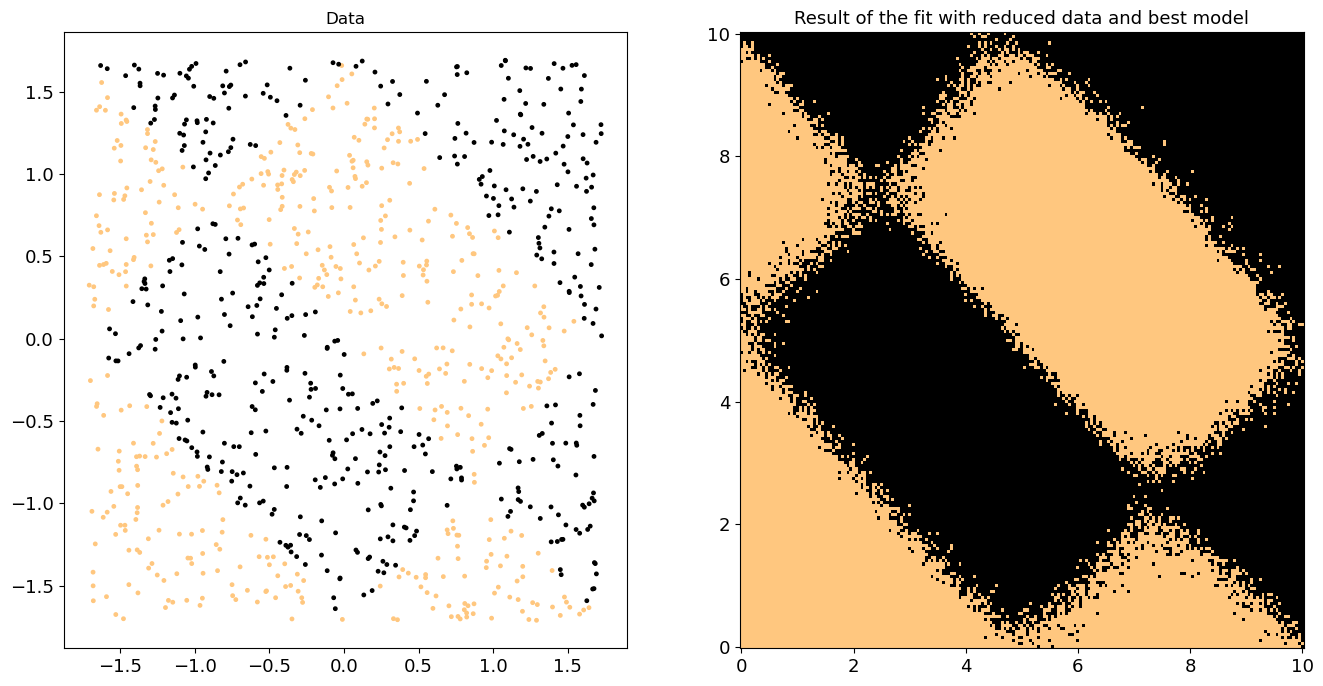

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


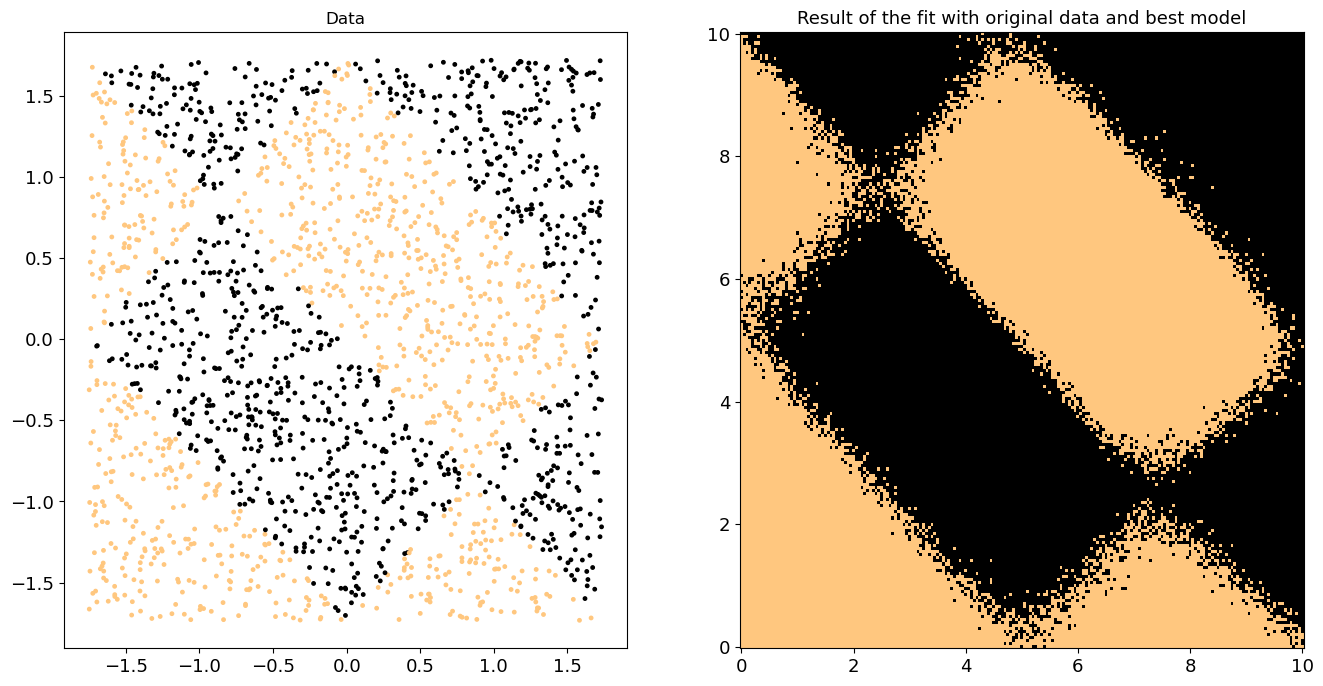

In [16]:
fit_h = models[0].fit(augm_data, augm_labels, epochs = nepoch, batch_size = 50, validation_data = (x_valid,y_valid), verbose=0)
##
dX = .05
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r = Standardize(grid, x_mean, x_std)

PlotPrediction(x, y, x_mean, x_std, bestModel, whichData = "original", whichModel= "best")

# PlotPrediction(xAugm, yAugm, x_mean, x_std, BestModel, whichData = "augmented", whichModel = "best")